In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import sys
sys.path.append('..')
from dataset import batcher

In [100]:
MODEL_DIR = '../saved_models/'
LR_RATE = 0.0001
OPT = tf.keras.optimizers.Adam(learning_rate=LR_RATE)
LOSS = 'MeanSquaredError'
METRICS = ['RootMeanSquaredError']

In [123]:
# Get test split
bands = ['BLUE', 'GREEN', 'RED', 'NIR', 'SW_IR1', 'SW_IR2', 'TEMP', 'VIIRS']
# bands = ['VIIRS']
test_batcher = batcher.Batcher(bands, country_year="ethiopia-2018", bucket=False, shuffle=False, split='test', repeat=1, batch_size=3000).get_dataset()
x_true = []
y_true = []
for x, y in test_batcher:
    x_true.append(x)
    y_true.append(y)

print(np.shape(x_true))

(1, 652, 224, 224, 8)


In [124]:
# Load model
experiments = ['imagery_sample_vgg_regression_ms_nl_200epochs']

def load_model_from_dir(model_name):
    model_path = MODEL_DIR + model_name + '.h5'
    model = tf.keras.models.load_model(model_path, compile=False)
    
    return model

In [125]:
# Get consumption predictions
trained_model = load_model_from_dir(experiments[0])
trained_model.compile(
            loss=LOSS,
            optimizer=OPT,
            metrics=METRICS,
        )

y_preds = trained_model.predict_on_batch(x_true)
print(y_preds)

2023-02-23 10:56:13.812513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[[-5.9732085e-01]
 [-3.0129674e-01]
 [ 8.8766843e-01]
 [-3.4593078e-01]
 [ 9.5053121e-02]
 [ 8.6126214e-01]
 [ 5.0668943e-01]
 [-3.1627646e-01]
 [-2.7217847e-01]
 [ 4.2559916e-01]
 [-3.5773104e-01]
 [-5.6103373e-01]
 [-1.0510711e-01]
 [ 3.5359499e-01]
 [-5.2306384e-01]
 [-4.5581868e-01]
 [ 1.1238408e-01]
 [ 1.1632494e+00]
 [-3.1851280e-01]
 [-5.3801745e-01]
 [-4.7081047e-01]
 [-2.5588679e-01]
 [-2.8346565e-01]
 [ 1.6416842e-01]
 [-2.3050691e-01]
 [ 5.7327884e-01]
 [ 2.3950176e-02]
 [-5.5099273e-01]
 [-1.5462406e-01]
 [ 2.5227675e-01]
 [-4.7832316e-01]
 [ 5.8256656e-01]
 [ 8.6969441e-01]
 [-4.6300825e-01]
 [ 1.1632494e+00]
 [-3.8432664e-01]
 [-5.0789410e-01]
 [-4.7784930e-01]
 [-2.2083320e-01]
 [-5.0860077e-01]
 [ 2.5842860e-01]
 [-4.0962350e-01]
 [ 2.0464809e-01]
 [-2.8190148e-01]
 [-5.1308507e-01]
 [-4.4764435e-01]
 [-5.4209071e-01]
 [-2.0016554e-01]
 [ 3.2735714e-01]
 [-3.8432664e-01]
 [ 1.2475269e+00]
 [-4.1748312e-01]
 [-1.9869746e-01]
 [-3.4958100e-01]
 [ 2.3935270e-01]
 [ 3.51158

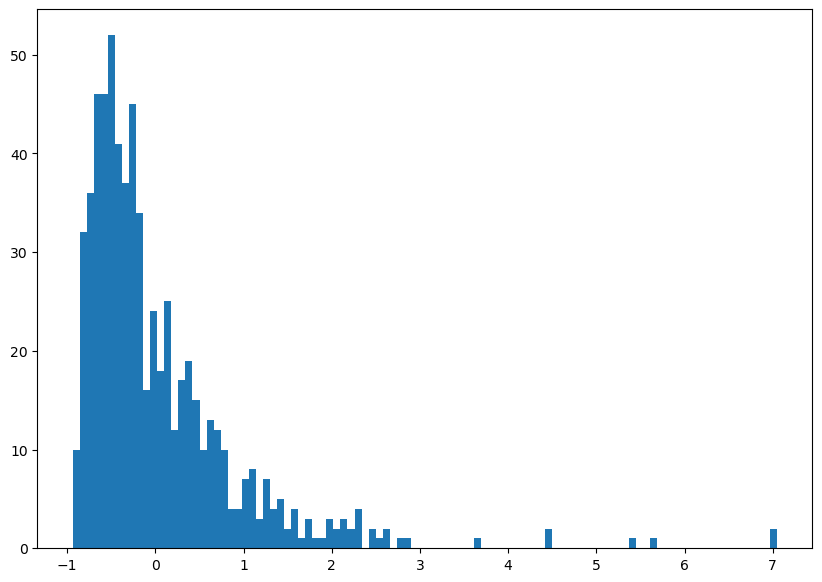

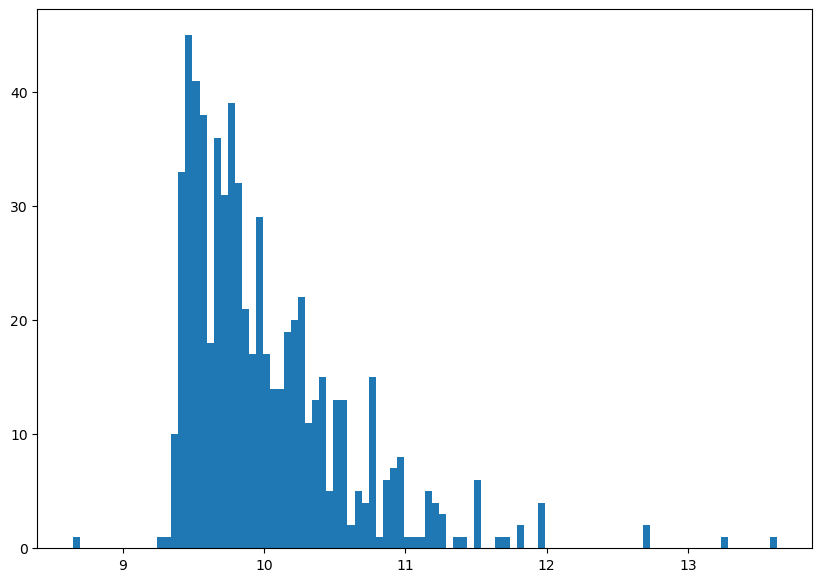

In [126]:
# Find r-squared
y_true = np.squeeze(y_true)
y_preds = np.squeeze(y_preds)
y_preds = y_preds + 10

# Plot histograms
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_true, bins = 100)
plt.show()

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_preds, bins = 100)
plt.show()

y_true = 2 * ((y_true - min(y_true)) / (max(y_true) - min(y_true))) - 1
y_preds =2 * ((y_preds - min(y_preds)) / (max(y_preds) - min(y_preds))) - 1

r2 = pearsonr(y_true, y_preds)[0]

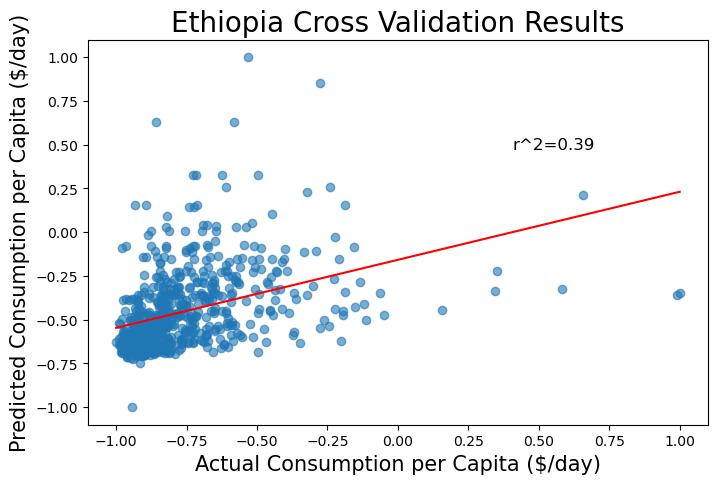

In [127]:
# Plot predictions
country = 'Ethiopia'
fig = plt.figure(figsize=(8,5))
plt.scatter(y_true, y_preds, alpha=0.6)
plt.plot(np.unique(y_true), np.poly1d(np.polyfit(y_true, y_preds, 1))(np.unique(y_true)), color='red')
plt.text(0.5, 0.5, f'r^2={round(r2, 2)}', ha='left', va='top', size=12, transform=ax.transAxes)
plt.xlabel('Actual Consumption per Capita ($/day)', fontsize=15)
plt.ylabel('Predicted Consumption per Capita ($/day)', fontsize=15)
plt.title(f'{country} Cross Validation Results', fontsize=20)
# plt.xlim([np.min(y_true), 10])
# plt.ylim([-2, np.max(y_preds)])
plt.show()